- The dataset can be found at the following link.
https://www.kaggle.com/grassknoted/asl-alphabet

In [1]:
# Import all the necessary dependencies

import os
import sys
import numpy as np
import pandas as pd
import plotly.express as px
import tqdm
import warnings
import matplotlib.pyplot as plt
import itertools

from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split
from PIL import Image
from timeit import default_timer as timer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import models
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import sampler


warnings.filterwarnings("ignore", category = FutureWarning)
%matplotlib inline
plt.rcParams["font.size"] = 14

print("Setup Complete!")
print("GPU Acceleration available: ", torch.cuda.is_available())

Setup Complete!
GPU Acceleration available:  True


# Exploratory Data Analysis

In [2]:
# The absolute path for where the dataset is saved 

DATA_PATH = "/media/rohan/4AF62396F6238175/Datasets/ASL/asl_alphabet_train/asl_alphabet_train/"

---
- We can get a feel of our data by parsing through all the subfolders.
- Here we see that there are 29 classes in total.
---

In [3]:
categories = glob(DATA_PATH + "*")

classes = [i.rsplit("/", 1)[-1] for i in categories]
print("The number of classes in the dataset are: ", len(classes))
print("The given datset contains the following classes: ", classes)

The number of classes in the dataset are:  29
The given datset contains the following classes:  ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


---
- The easiest way to perform EDA is with a dataframe
- We will use Pandas for this purpose
<br><br>
- We will start by parsing through the dataset.
- For each image encountered, we will save the path in the "Filepath" column.
- We will use the name of the folder as the label for that image.
---

In [4]:
filedf = pd.DataFrame()

for cat in categories:
    files = glob(cat + "/*")
    tempdf = pd.DataFrame({"filepath": files, "category": cat.split("/")[-1]})
    filedf = pd.concat([filedf, tempdf])

In [5]:
filedf.head()

filepath category
0  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A
1  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A
2  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A
3  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A
4  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A

---
- Next, we can see the distriution of all the images in each class.
- We can see that all images have an equal distribution.
- This makes our job a lot easier as there won't be any under represented class
---

In [6]:
groupby_count = filedf.groupby("category").aggregate('count').rename(columns = {'filepath':'count'}).reset_index()
groupby_count.value_counts()

category  count
A         3000     1
P         3000     1
nothing   3000     1
del       3000     1
Z         3000     1
Y         3000     1
X         3000     1
W         3000     1
V         3000     1
U         3000     1
T         3000     1
S         3000     1
R         3000     1
Q         3000     1
O         3000     1
B         3000     1
N         3000     1
M         3000     1
L         3000     1
K         3000     1
J         3000     1
I         3000     1
H         3000     1
G         3000     1
F         3000     1
E         3000     1
D         3000     1
C         3000     1
space     3000     1
dtype: int64

In [7]:
groupby_count = filedf.groupby("category").aggregate('count').rename(columns = {'filepath':'count'}).reset_index()

fig = px.bar(groupby_count, x = 'category', y = 'count', color = 'category', title = 'Counts from Each Category')
fig.show()
fig.write_image("classes_distribution.png")

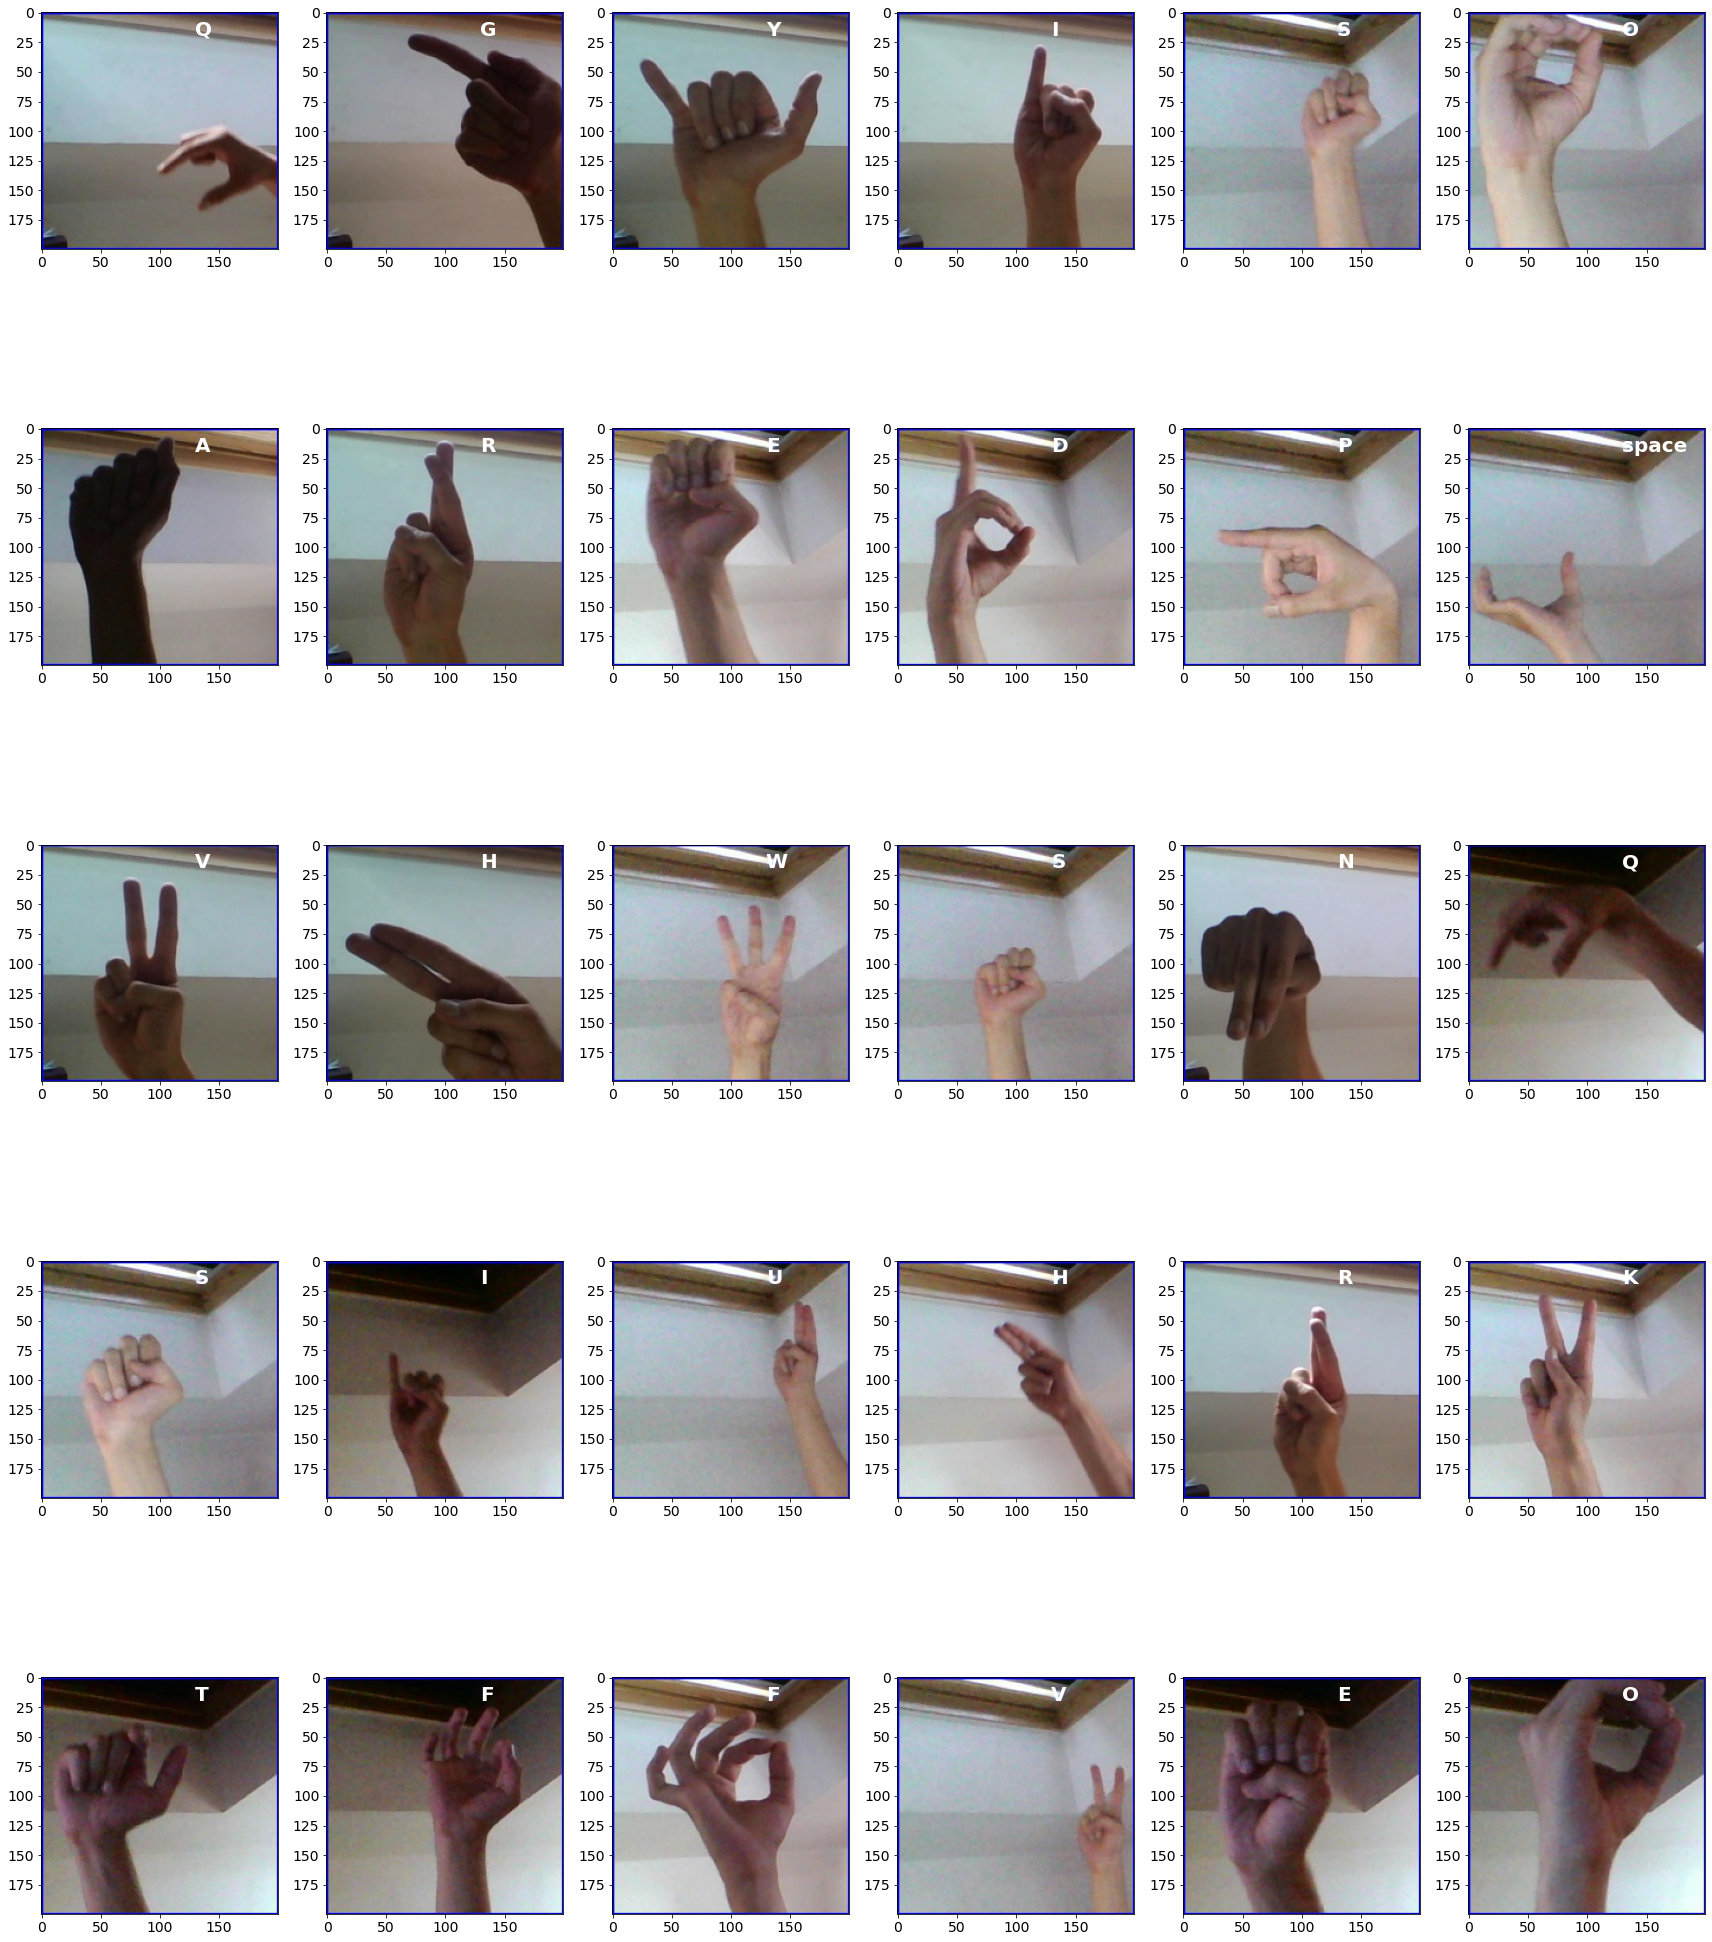

In [8]:
plt.figure(figsize = (24, 30))

for i in range(30):
    path = filedf.sample(1)['filepath'].values[0]
    category = path.split("/")[-2]
    ex_img = Image.open(path)
    ax = plt.subplot(5, 6, i + 1)
    ax.annotate(category, xy = (0.65, 0.9), xycoords = "axes fraction", weight = 'bold', color = "white", size = 20)
    ax.imshow(ex_img)

plt.tight_layout()

In [9]:
filedf.head()

filepath category
0  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A
1  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A
2  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A
3  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A
4  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        A

---
- We can split this dataset into train, test and validation sets for training.
- As we already have a dataframe ready, we can use scikit learn's train_test_split function.
<br><br>
- As the train_test_split function only performs 1 split (train and test), and we need 2 splits (train, test and valid), we need to call the function twice.
- The ratio for split is 60 : 20 : 20, i.e. 60% images in the Train set, and 20% images each in Test and Validation set.
<br><br>
- An important argument here is the "stratify".
- This will ensure that each class will have the same distribution percentage even after the split.
- Hence, we won't have any under represented classes in the Test and Validation sets even after the split
---

In [10]:
X_train, X_test, _, _ = train_test_split(filedf, filedf["category"], 
                                         stratify = filedf["category"], test_size = 0.4, random_state = 42)


X_test, X_val, _, _ = train_test_split(X_test, X_test['category'], 
                                       stratify = X_test['category'], test_size = 0.5, random_state = 42)

---
- Now that we have our splits, we can see if an image belongs to train, test or valid category.
- We can append this information to our dataframe.
---

In [11]:
X_train["type"] = "train"
X_test["type"] = "test"
X_val["type"] = "val"

<ipython-input-11-4df488eb6ec0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



---
- As a sanity check, we can see if our dataset has actually been correctly split.
---

In [12]:
fulldf = pd.concat([X_train, X_test, X_val])
fulldf.type.value_counts()

train    52200
test     17400
val      17400
Name: type, dtype: int64

In [13]:
fulldf.head()

filepath category   type
1620  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        W  train
1939  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        M  train
1281  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        H  train
2439  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        I  train
2729  /media/rohan/4AF62396F6238175/Datasets/ASL/asl...        T  train

---
- Now we perform the actual split.
<br><br>
- Our directory structure will change from :-<br>
    - Dataset -> A, B, ...
- To:-<br>
    - Train -> A, B, ... | Test -> A, B, ... | Valid -> A, B, ...
---

- First, we make the empty directories
---

In [14]:
fulldf.category.unique()

array(['W', 'M', 'H', 'I', 'T', 'Q', 'G', 'L', 'V', 'J', 'P', 'del', 'U',
       'A', 'space', 'R', 'X', 'nothing', 'D', 'C', 'Z', 'E', 'K', 'B',
       'O', 'S', 'N', 'Y', 'F'], dtype=object)

In [15]:
if not os.path.exists("./data"):
    os.makedirs("./data")
    
    if not os.path.exists("./data/train"):
        os.makedirs("./data/train")        
        for cat in fulldf.category.unique():
            os.system(f"mkdir data/train/'{cat}'") 
        
    if not os.path.exists("./data/val"):
        os.makedirs("./data/val")        
        for cat in fulldf.category.unique():
            os.system(f"mkdir data/val/'{cat}'") 
        
    if not os.path.exists("/data/test"):
        os.makedirs("./data/test")        
        for cat in fulldf.category.unique():
            os.system(f"mkdir data/test/'{cat}'") 

- Here we copy the original image from the original path to our specified path

In [16]:
for i,row in fulldf.iterrows():
    cat = row['category']
    section = row['type']
    ipath = row['filepath']
    opath = ipath.replace(DATA_PATH, f"./data/{section}/")
    os.system(f"cp '{ipath}' '{opath}'")

---
---
---

---
# Preprocessing and Augmentation

---
- We can start by checking the numebr of directories.
- We can also count how many images are available in the original dataset.
---

In [17]:
categories = []
for classes in os.listdir(DATA_PATH):
    categories.append(classes)
    
n_classes = len(categories)
print(f'There are {n_classes} different classes.')

There are 29 different classes.


In [18]:
original_count = sum(len(images) for _, _, images in os.walk(DATA_PATH))

print(original_count, "Images are available for training")

87000 Images are available for training


---
- Now we can see that the original dataset has 87000 images available.
- From those 87000 images, we performed a split with the ratio 60 : 20 : 20.
<br><br>
- So we should be able to verify how many images we actually have after the split
---

In [19]:
train_count = sum(len(images) for _, _, images in os.walk(os.path.join("./data", "train")))
valid_count = sum(len(images) for _, _, images in os.walk(os.path.join("./data", "val")))
test_count = sum(len(images) for _, _, images in os.walk(os.path.join("./data", "test")))

print(f"After split, the train folder should have {int(np.round(original_count * 0.6))} images")
print(f"After split, the valid folder should have {int(np.round(original_count * 0.2))} images")
print(f"After split, the test folder should have {int(np.round(original_count * 0.2))} images")
print("\n")
print("Images are actually available in the train folder", train_count)
print("Images are actually available in the valid folder", valid_count)
print("Images are actually available in the test folder", test_count)

After split, the train folder should have 52200 images
After split, the valid folder should have 17400 images
After split, the test folder should have 17400 images


Images are actually available in the train folder 52200
Images are actually available in the valid folder 17400
Images are actually available in the test folder 17400


---
- Once we have verified that the split is in fact correct, we can move on to the augmentations.
- The train set will have the most number of augmentations as we want to make our dataset as robust as possible.
- The valid and test dataset will not have any transforms that will change the attributes.
- Instead they will only take care of resizing the images, normalizing them and converting them to Pytorch tensors
---

In [20]:
image_transforms = {"train": transforms.Compose([transforms.RandomResizedCrop(size = 256, scale = (0.8, 1.0)),
                                                 transforms.RandomRotation(degrees = 15),
                                                 transforms.ColorJitter(),
                                                 transforms.GaussianBlur(kernel_size = 3),
                                                 transforms.CenterCrop(size = 224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                                      [0.229, 0.224, 0.225]),
                                                ]),
                    
                    "valid": transforms.Compose([transforms.Resize(size = 256),
                                                 transforms.CenterCrop(size = 224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                                      [0.229, 0.224, 0.225]),
                                                ]),
                   
                    "test": transforms.Compose([transforms.Resize(size = 256),
                                                 transforms.CenterCrop(size = 224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                                      [0.229, 0.224, 0.225]),
                                                ]),
                   }

---
- Since we Pytorch is used, the images will be in a Tensor format.
- To display these Tensors as images, we need to preprocess them first.
<br><br>
- The tensors are stored in Pytorch in the format (Channels x Height x Width)
- We will first need to convert them to the (Height x Width x Channels) format compatible with matplotlib
<br><br>
- Next, we will reverse the normalization applied during data augmentation
- We can display the images after that
---

In [21]:
def imshow_tensor(image, ax = None, title = None):
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

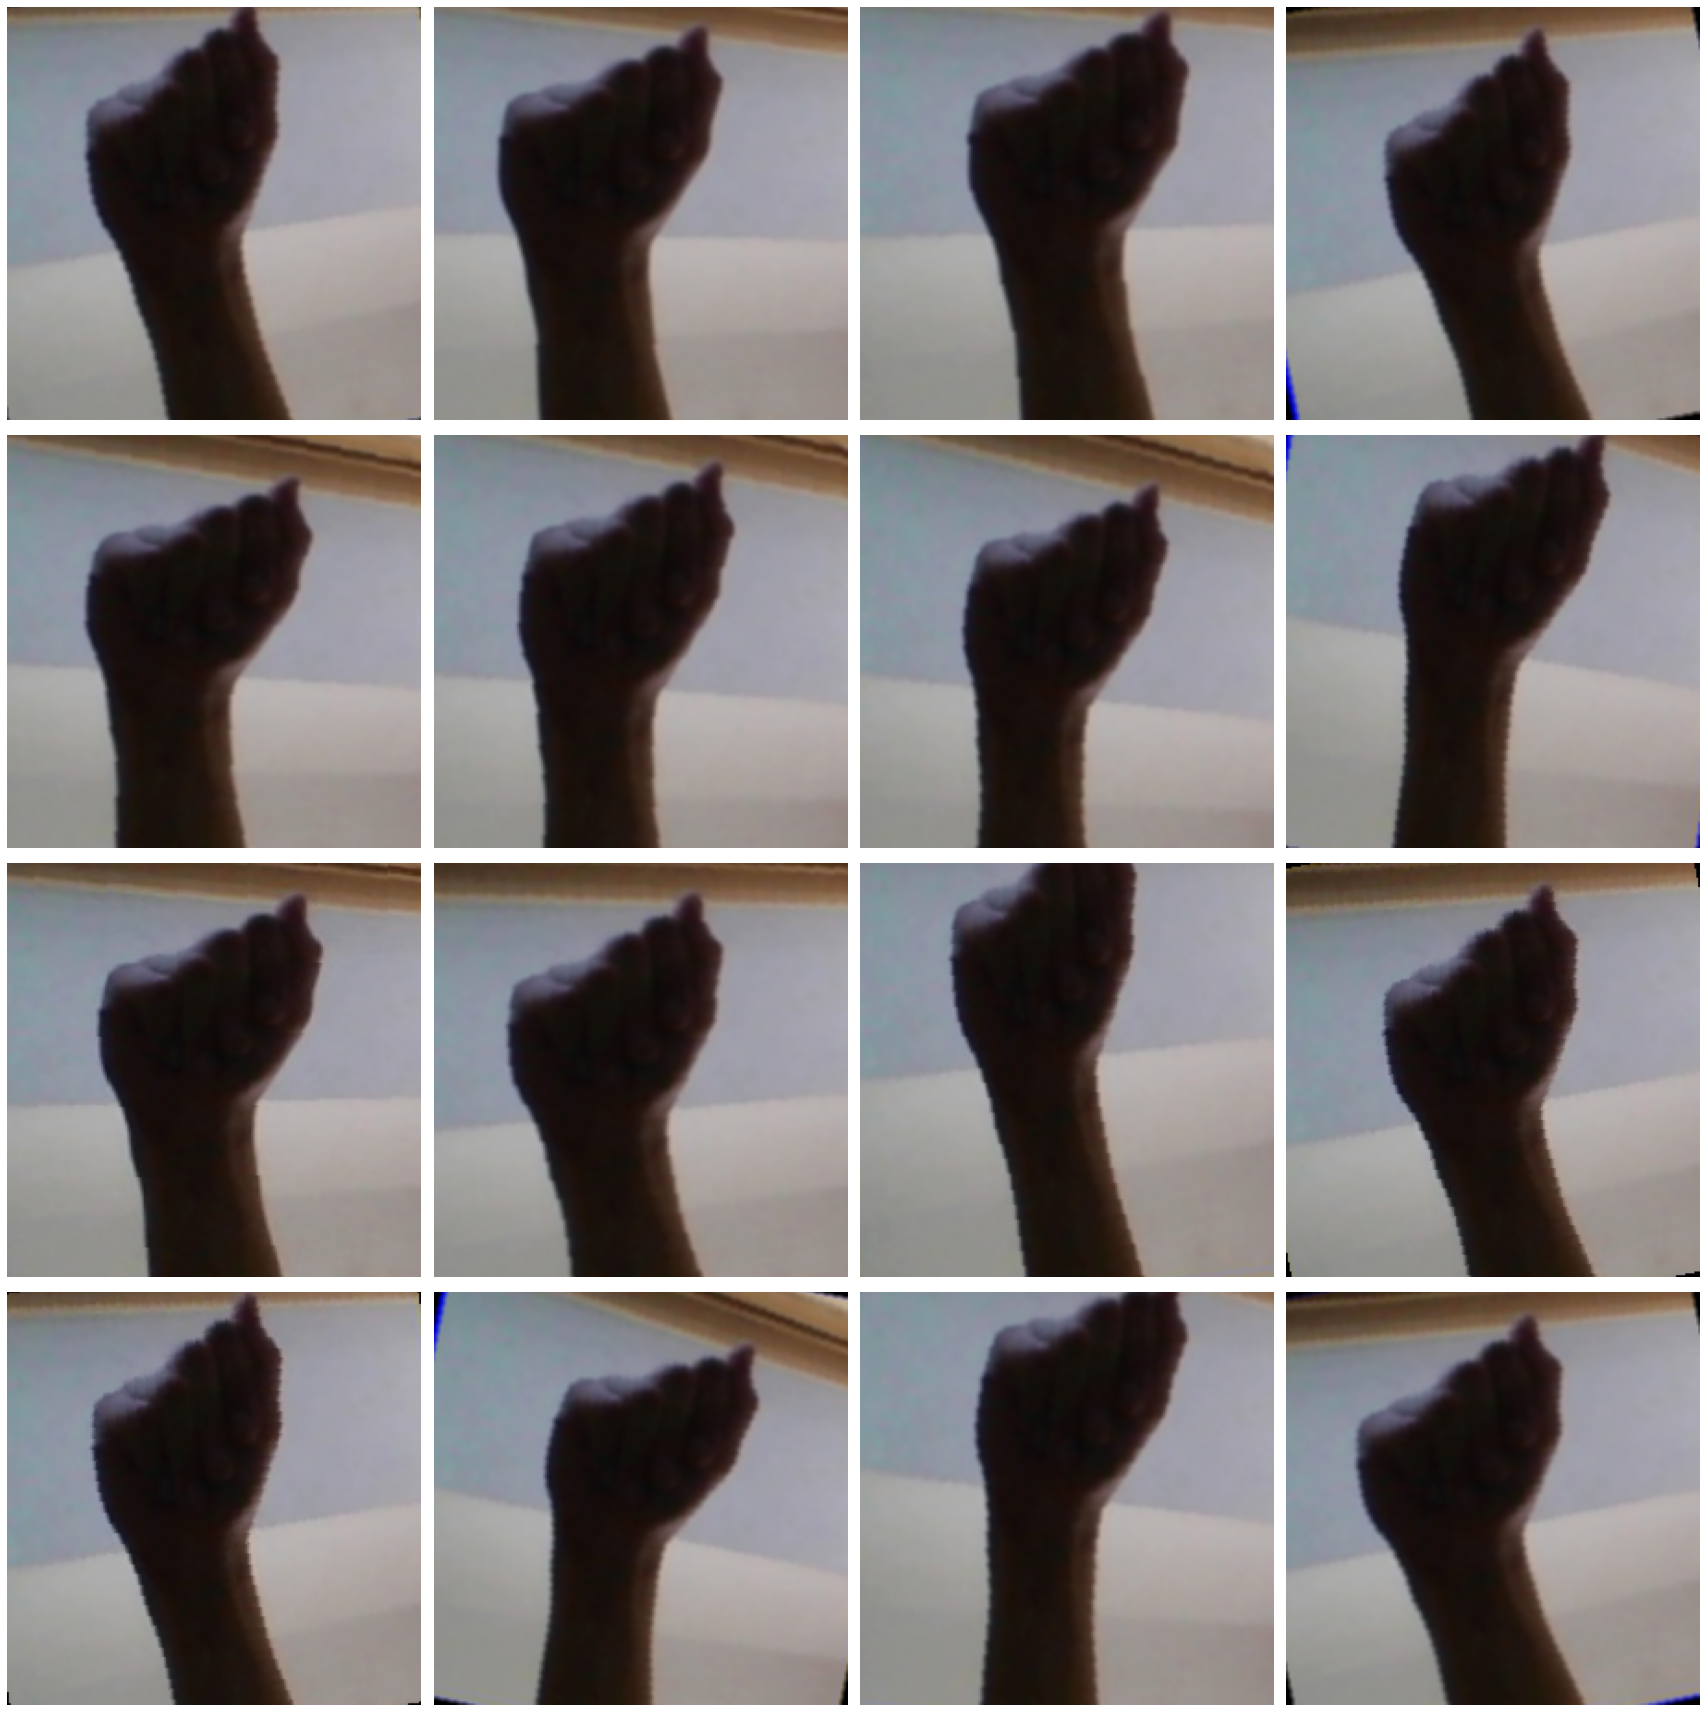

In [22]:
# Check the Augmentations on a random image

random_img = Image.open(os.path.join("./data", "train", "A", "A1.jpg"))

t = image_transforms['train']
plt.figure(figsize = (24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(random_img), ax = ax)

plt.tight_layout()

---
---
---

# Deep Learning
---

---
- First we will start by defining the Batch size and the device.
---

In [23]:
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("GPU Acceleration available!")
else:
    print("Training will use GPU")

Training will use GPU


---
- The augmented data, along with the test and valid data can be loaded using the Pytorch DataLoader
---

In [24]:
data = {"train": datasets.ImageFolder(root = os.path.join("./data", "train"), 
                                      transform = image_transforms["train"],
                                     ),
        
        "valid": datasets.ImageFolder(root = os.path.join("./data", "val"),
                                      transform = image_transforms["valid"],
                                     ),
       
        "test": datasets.ImageFolder(root = os.path.join("./data", "test"),
                                     transform = image_transforms["test"],
                                    ),
       }

dataloaders = {"train": DataLoader(data["train"], batch_size = batch_size, shuffle = True),
               "test": DataLoader(data["test"], batch_size = batch_size, shuffle = True),
               "valid": DataLoader(data["valid"], batch_size = batch_size, shuffle = False)
              }

---
- Now we can perform another sanity check to see if our dataset is in order.
<br><br>
- We know that during batch loading, the shape of the entire batch should be of the format:
    (Batch_Size x Channels x Height x Width).

- We also know that the corresponding labels of that batch should have the shape (Batch_Size).
---

In [25]:
trainiter = iter(dataloaders["train"])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [26]:
class_to_idx = data['train'].class_to_idx
idx_to_class = {idx: class_ for class_, idx in data['train'].class_to_idx.items()}


train_counts = Counter([idx_to_class[x] for x in data['train'].targets])
val_counts = Counter([idx_to_class[x] for x in data['valid'].targets])
test_counts = Counter([idx_to_class[x] for x in data['test'].targets])

In [27]:
train_counts = pd.DataFrame({'category': list(train_counts.keys()), 'train_count': list(train_counts.values())})
val_counts = pd.DataFrame({'category': list(val_counts.keys()), 'val_count': list(val_counts.values())})
test_counts = pd.DataFrame({"category": list(test_counts.keys()), 'test_count': list(test_counts.values())})

count_df = pd.merge(train_counts, val_counts, on = 'category', how = 'left')

count_df.head(30)

category  train_count  val_count
0         A         1800        600
1         B         1800        600
2         C         1800        600
3         D         1800        600
4         E         1800        600
5         F         1800        600
6         G         1800        600
7         H         1800        600
8         I         1800        600
9         J         1800        600
10        K         1800        600
11        L         1800        600
12        M         1800        600
13        N         1800        600
14        O         1800        600
15        P         1800        600
16        Q         1800        600
17        R         1800        600
18        S         1800        600
19        T         1800        600
20        U         1800        600
21        V         1800        600
22        W         1800        600
23        X         1800        600
24        Y         1800        600
25        Z         1800        600
26      del         1800        600
27  nothing         1800        600
28    space         1800        600

---
- We can define out model now
---

---
- The neural network used here is AlexNet.
<br><br>
- Here's the link to the original paper.
https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [28]:
class ASLNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = n_classes):
        super(ASLNet, self).__init__()
        
        self.features = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size = 11, stride = 4, padding = 2),
                                      nn.ReLU(inplace = True),
                                      nn.MaxPool2d(kernel_size = 3, stride = 2),
                                      
                                      nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
                                      nn.ReLU(inplace = True),
                                      nn.MaxPool2d(kernel_size = 3, stride = 2),
                                      
                                      nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
                                      nn.ReLU(inplace = True),
                                      
                                      nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
                                      nn.ReLU(inplace = True),
                                      
                                      nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
                                      nn.ReLU(inplace = True),
                                      nn.MaxPool2d(kernel_size = 3, stride = 2),
                                     )
        
        self.classifier = nn.Sequential(nn.Linear(256 * 6 * 6, 4096),
                                        nn.ReLU(inplace = True),
                                        nn.Linear(4096, 4096), 
                                        nn.ReLU(inplace = True), 
                                        nn.Linear(4096, out_channels),
                                       )
       
    
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [29]:
model = ASLNet()

In [30]:
for param in model.parameters():
    param.requires_grad = True

In [31]:
print(model)

ASLNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=4096, bias=True)


---
- Get the count of the total number of parameters.
---

In [32]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Total Trainable Parameters: {trainable_params:,}")

Total Parameters: 57,122,653
Total Trainable Parameters: 57,122,653


- Now we can shift the model to the GPU

In [33]:
model = model.to(device)

---
- Since we have 29 classes, we need to convert them into encoded labels, so we can use them to train our model.
---

In [34]:
model.class_to_idx = data["train"].class_to_idx
model.idx_to_class = {idx: class_ for class_, idx in model.class_to_idx.items()}

list(model.idx_to_class.items())[:30]

[(0, 'A'),
 (1, 'B'),
 (2, 'C'),
 (3, 'D'),
 (4, 'E'),
 (5, 'F'),
 (6, 'G'),
 (7, 'H'),
 (8, 'I'),
 (9, 'J'),
 (10, 'K'),
 (11, 'L'),
 (12, 'M'),
 (13, 'N'),
 (14, 'O'),
 (15, 'P'),
 (16, 'Q'),
 (17, 'R'),
 (18, 'S'),
 (19, 'T'),
 (20, 'U'),
 (21, 'V'),
 (22, 'W'),
 (23, 'X'),
 (24, 'Y'),
 (25, 'Z'),
 (26, 'del'),
 (27, 'nothing'),
 (28, 'space')]

- Now we can define the Optimizer and Loss Function

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

--- 
## Training Loop

In [36]:
def train(model, criterion, optimizer, train_loader, valid_loader, save_file_name, max_epochs_stop = 5,
          n_epochs = 100, print_every = 1):

    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    try:
        print(f"Model has been trained for: {model.epochs} epochs\n")
    except:
        model.epochs = 0
        print(f"Starting Training from Scratch.\n")

    overall_start = timer()

    
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        start = timer()

        for ii, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            _, pred = torch.max(output, dim = 1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            
            loss = criterion(output, target)
            train_loss += loss.item() * data.size(0)

            loss.backward()
            optimizer.step()

            print(f"Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.", end = "\r")

        else:
            model.epochs += 1

            with torch.no_grad():
                model.eval()

                for data, target in valid_loader:
                    data, target = data.to(device), target.to(device)

                    output = model(data)
                    _, pred = torch.max(output, dim = 1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)

                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)

                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                if (epoch + 1) % print_every == 0:
                    print(f"\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}")
                    print(f"\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%")
                    print("=" * 50); print("\n")
                    
                if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_file_name)
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= max_epochs_stop:
                        print(f"\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%")
                        total_time = timer() - overall_start
                        print(f"{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.")

                        model.load_state_dict(torch.load(save_file_name))
                        model.optimizer = optimizer

                        history = pd.DataFrame(history, columns = ['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
                        return model, history

    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(f"\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%")
    print(f"{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.")
    print("\n")

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

    return model, history

In [37]:
model, history = train(model, 
                       criterion, 
                       optimizer, 
                       dataloaders["train"], 
                       dataloaders["valid"], 
                       save_file_name = "ASLNet.pt", 
                       max_epochs_stop = 5,
                       n_epochs = 10, 
                       print_every = 1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 243.86 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.4478 	Validation Loss: 0.2828
		Training Accuracy: 54.81%	 Validation Accuracy: 90.14%


Epoch: 1	100.00% complete. 240.96 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.2948 	Validation Loss: 0.1398
		Training Accuracy: 89.92%	 Validation Accuracy: 95.60%


Epoch: 2	100.00% complete. 250.09 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.1862 	Validation Loss: 0.1111
		Training Accuracy: 93.79%	 Validation Accuracy: 95.97%


Epoch: 3	100.00% complete. 267.07 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.1656 	Validation Loss: 0.0591
		Training Accuracy: 94.65%	 Validation Accuracy: 97.93%


Epoch: 4	100.00% complete. 267.37 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.1481 	Validation Loss: 0.1044
		Training Accuracy: 95.30%	 Validation Accuracy: 96.48%


Epoch: 5	100.00% complete. 266.17 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.

---
- We can plot the evaluation metrics
---

Text(0.5, 1.0, 'Training and Validation Loss')

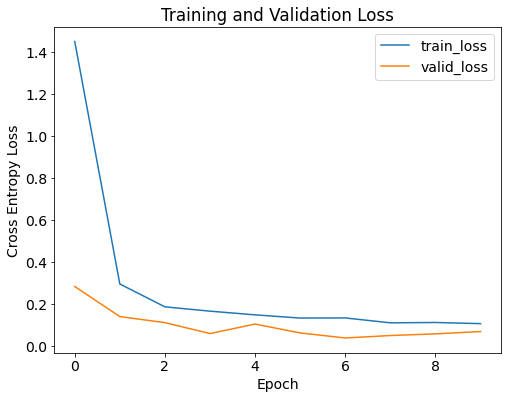

In [38]:
plt.figure(figsize = (8, 6))

for c in ["train_loss", "valid_loss"]:
    plt.plot(history[c], label = c)
    
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training and Validation Loss")

Text(0.5, 1.0, 'Training and Validation Accuracy')

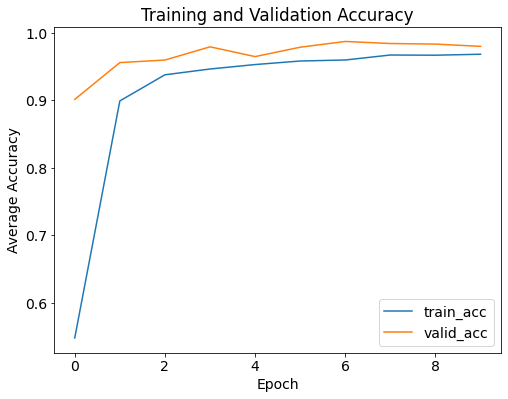

In [39]:
plt.figure(figsize = (8, 6))

for c in ["train_acc", "valid_acc"]:
    plt.plot(history[c], label = c)
    
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Accuracy")
plt.title("Training and Validation Accuracy")

---
- Now we can save the model weights
---

In [40]:
def save_checkpoint(model, path):
    checkpoint = {"class_to_idx": model.class_to_idx,
                  "idx_to_class": model.idx_to_class,
                  "epochs": model.epochs}
    
    checkpoint["classifier"] = model.classifier
    checkpoint["state_dict"] = model.state_dict()
    checkpoint["optimizer"] = model.optimizer
    checkpoint["optimizer_state_dict"] = model.optimizer.state_dict()
    
    torch.save(checkpoint, path)

In [41]:
save_checkpoint(model, path = "./ASLNet.pth")

---
---
---

# Inference
---

---
- We can start by loading in the model and checking the parameters to see if it is loaded correctly
---

In [42]:
class ASLNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = n_classes):
        super(ASLNet, self).__init__()
        
        self.features = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size = 11, stride = 4, padding = 2),
                                      nn.ReLU(inplace = True),
                                      nn.MaxPool2d(kernel_size = 3, stride = 2),
                                      
                                      nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
                                      nn.ReLU(inplace = True),
                                      nn.MaxPool2d(kernel_size = 3, stride = 2),
                                      
                                      nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
                                      nn.ReLU(inplace = True),
                                      
                                      nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
                                      nn.ReLU(inplace = True),
                                      
                                      nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
                                      nn.ReLU(inplace = True),
                                      nn.MaxPool2d(kernel_size = 3, stride = 2),
                                     )
        
        self.classifier = nn.Sequential(nn.Linear(256 * 6 * 6, 4096),
                                        nn.ReLU(inplace = True),
                                        nn.Linear(4096, 4096), 
                                        nn.ReLU(inplace = True), 
                                        nn.Linear(4096, out_channels),
                                       )
       
    
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [43]:
print(model)

ASLNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=4096, bias=True)


In [44]:
def load_checkpoint(path):
    
    checkpoint = torch.load(path)
    #print(checkpoint)
    
    model = ASLNet()
    for param in model.parameters():
        param.requires_grad = False
    
    model.classifier = checkpoint["classifier"]
    
    model.load_state_dict(checkpoint["state_dict"])
    
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f'Total Parameters: {total_params:,}')
    print(f'Total gradient parameters: {total_trainable_params:,}')
    
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [45]:
model, optimizer = load_checkpoint(path = "./ASLNet.pth")

Total Parameters: 57,122,653
Total gradient parameters: 54,652,957


---
- We can check the accuracy of our model by using the function below.
- Here, we will calculate the Top-k accuracy, which means that will give the output of the top K predictions from the total number of classes.
---

In [46]:
def accuracy(output, target, topk = (1, )):
    output = output.to('cuda')
    target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(k = maxk, dim = 1, largest = True, sorted = True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim = True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

---
- We can test out our model on the test set.
- We will start by creating a dummy confusion matrix.
- Then, for each image, we will make a prediction.
- For each prediction made, we will evaluate it and append the count to the confusion matrix.
- This way, we will be avle to tell about the True and False predictions, and will also give an idea about how to handle our dataset
---

In [47]:
def evaluate(model, test_loader, criterion, topk = (1, 3, 5)):
    confusion_matrix = torch.zeros(n_classes, n_classes)
    classes = []
    losses = []
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model = model.to(device)
    model.eval()
    with torch.no_grad():

        for data, targets in test_loader:

            data, targets = data.to(device), targets.to(device)

            out = model(data)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            
            for pred, true in zip(out, targets):
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'}),confusion_matrix

criterion = nn.NLLLoss()
results,confusion_matrix = evaluate(model, dataloaders['test'], criterion)

In [48]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'confusion_matrix.png')
    return plt

Confusion matrix, without normalization


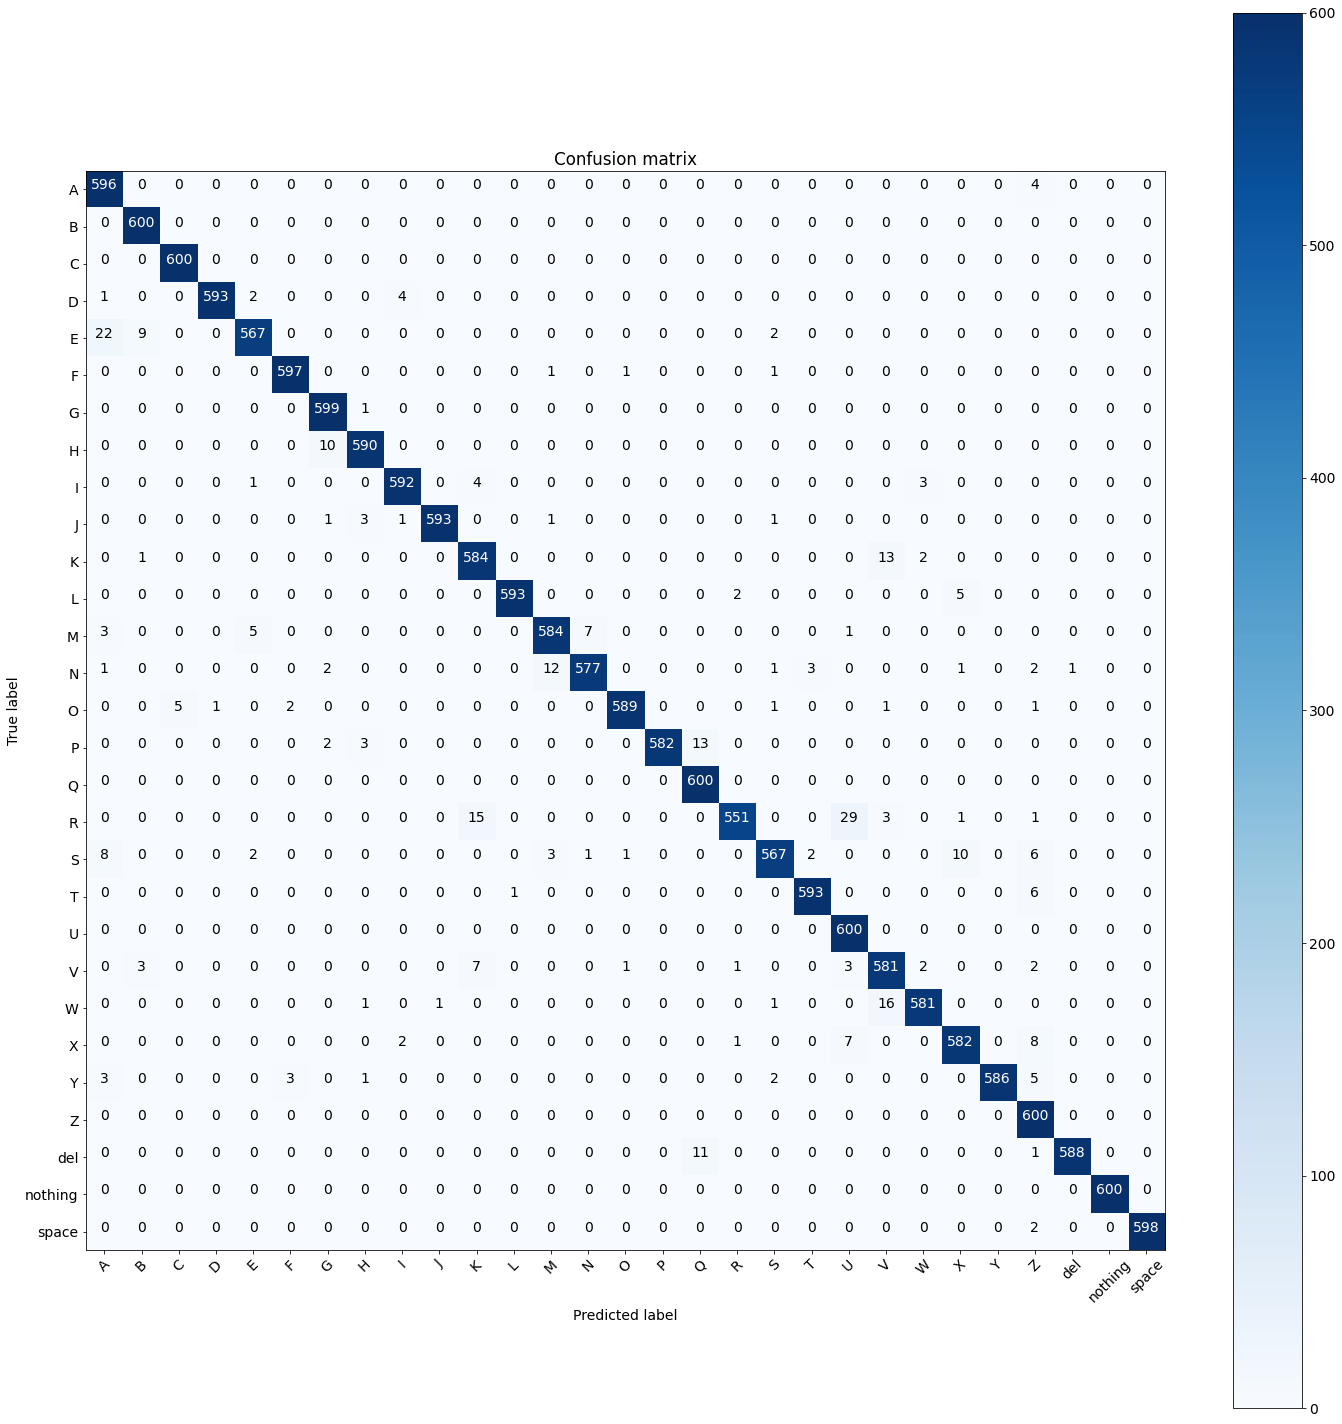

In [49]:
classnames = [model.idx_to_class[i] for i in range(0, n_classes)]


plt.figure(figsize = (20, 20))
plt = plot_confusion_matrix(confusion_matrix, classnames)

---
- If we want to test a custom image, we need to perform the same preprocessing operations as we did on our training set, so that it will be compatible with our model.
- For our training set, we require our images to be of the size (224, 224), so we will resize the image first.
- Then we will normalize it and convert it to a tensor.
- We can then predict the image.
---

In [50]:
def process_image(image_path):
    image = Image.open(image_path)
    img = image.resize((256, 256))
    
    width = 256
    height = 256
    new_width = 224
    new_height = 224
    
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))
    
    img = np.array(img).transpose((2, 0, 1)) / 256

    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

---
- The Predict function will also give the Top-k prediction on the image
- The prediction is clipped to give a value between 0 and 1
---

In [51]:
def predict(image_path, model, topk = 5):
    real_class = image_path.split("/")[3]
    
    img_tensor = process_image(image_path)
    img_tensor = img_tensor.view(1, 3, 224, 224)

    with torch.no_grad():
        model = model.to("cpu")
        model.eval()

        out = model(img_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(topk, dim = 1)

        top_classes = [model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

---
---
---

# Testing
---

---
- Now we can take a random image from the test set and predict it using our trained model
---

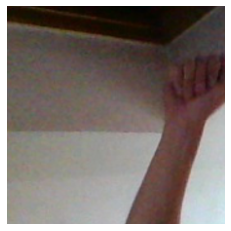

In [52]:
np.random.seed = 100


def random_test_image():
    c = np.random.choice(categories)
    root = "./data/test/" + c + "/"
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [53]:
img, top_p, top_classes, real_class = predict(random_test_image(), model,topk = 5)

In [54]:
top_p, top_classes, real_class

(array([2.0277916e+15, 2.7273472e+06, 1.2933990e-01, 6.0567139e-03,
        1.8695628e-06], dtype=float32),
 ['H', 'G', 'P', 'J', 'del'],
 'H')

In [55]:
def display_prediction(image_path, model, topk):
    img, ps, classes, y_obs = predict(image_path, model, topk)
    result = pd.DataFrame({'p': ps}, index = classes)

    plt.figure(figsize = (16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax = ax)

    ax.set_title("True Prediction: " + y_obs, size = 20)

    ax = plt.subplot(1, 2, 2)
    result.sort_values('p')['p'].plot.barh(color = 'blue', edgecolor = 'k', ax = ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

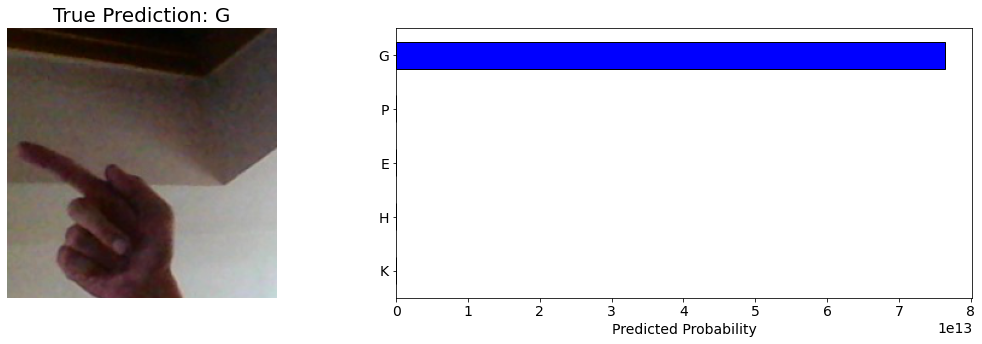

In [56]:
display_prediction(random_test_image(), model, topk = 5)